## Imports and Intallations

In [ ]:
!pip install lightgbm

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, f1_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, fbeta_score, roc_auc_score, classification_report, precision_score, precision_recall_curve
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_val_score


In [ ]:
# Adjust pandas display options to show all columns
pd.set_option('display.max_columns', None)

## Input

In [ ]:
# Loading the data to dataframe to futhur process
df = pd.read_csv('Vodafone_Customer_Churn_Sample_Dataset.csv')

In [ ]:
# Checking the size of the database
df.shape

(7043, 21)

In [ ]:
# Checking the data
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# Check if the 'ID' column has unique values
is_id_unique = df['customerID'].nunique() == len(df)
print(f"Is 'ID' column unique? {is_id_unique}")

Is 'ID' column unique? True


In [ ]:
# Set the 'ID' column as the index
df = df.set_index('customerID')


In [ ]:
# Checking the input data types
df.dtypes

,0
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object
OnlineBackup,object


In [ ]:
# Count missing values in each column
missing_values_per_column = df.isnull().sum()
print(missing_values_per_column)

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


## Feature Engineering

In [ ]:
# Convert to numeric, coerce errors to NaN
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Replace NaN with 0 or better: median/mean
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

print("Any NaN:", df["TotalCharges"].isnull().values.any())

Any NaN: False


/tmp/ipython-input-2149202393.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)


In [ ]:
# Encode target variable
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

In [ ]:
df_fe = df.copy()

# Tenure buckets
df_fe["tenure_bucket"] = pd.cut(
    df_fe["tenure"],
    bins=[0, 6, 24, 72],   # 0–6, 6–24, 24+
    labels=["0-6", "6-24", "24+"],
    include_lowest=True
)

# Service count
service_cols = [
    "PhoneService", "MultipleLines", "InternetService", "OnlineSecurity",
    "OnlineBackup", "DeviceProtection", "TechSupport",
    "StreamingTV", "StreamingMovies"
]
df_fe["service_count"] = (df_fe[service_cols] == "Yes").sum(axis=1)

# Contract length indicator
df_fe["is_monthly_contract"] = (df_fe["Contract"] == "Month-to-month").astype(int)

# Spend ratio (avg monthly spend)
df_fe["spend_ratio"] = df_fe["TotalCharges"].astype(float) / (df_fe["tenure"] + 1)

# Interaction feature example: InternetService × TechSupport
df_fe["fiber_no_support"] = (
    (df_fe["InternetService"] == "Fiber optic") & (df_fe["TechSupport"] == "No")
).astype(int)

df_fe = df_fe.drop(columns=["tenure"], axis=1)

In [ ]:
# Checking the data after the feature engineering
df_fe.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_bucket,service_count,is_monthly_contract,spend_ratio,fiber_no_support
customerID,,,,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0-6,1,1,14.925000,0
5575-GNVDE,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,24+,3,0,53.985714,0
3668-QPYBK,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,0-6,3,1,36.050000,0
7795-CFOCW,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,24+,3,0,40.016304,0
9237-HQITU,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,0-6,1,1,50.550000,1


## Splitting the data

In [ ]:
# Split features & target
X = df_fe.drop("Churn", axis=1)
y = df_fe["Churn"]

In [ ]:
num_cols = [ "MonthlyCharges", "TotalCharges", "spend_ratio"]
keep_cols = ["service_count"]  # keep untouched
cat_cols = [c for c in X.columns if c not in num_cols + keep_cols]

In [ ]:
# Converting categorical variables into numarical by using get_dummies
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

In [ ]:
#
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)

Train size: (5634, 35)  Test size: (1409, 35)


## Outliers

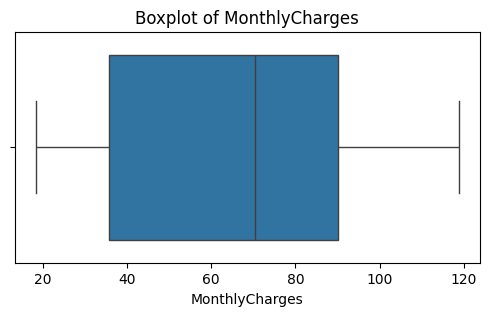

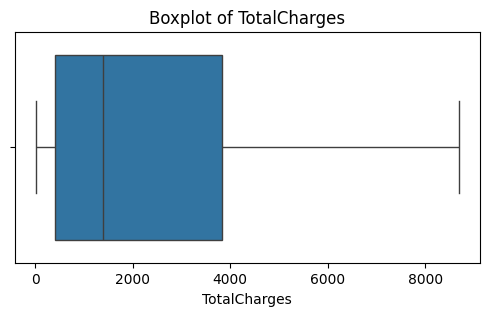

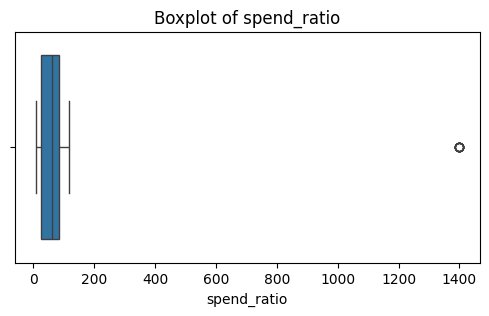

In [ ]:
# Box plot to check for the outliers
for col in num_cols:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=X_train[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

Outliers were detected exclusively in the spend_ratio column, as evidenced by the box plot analysis.

In [ ]:
# Checking number of outliers per column
def find_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    return df[(df[col] < lower) | (df[col] > upper)]

for col in num_cols:
    outliers = find_outliers(X_train, col)
    print(f"{col}: {len(outliers)} outliers")

MonthlyCharges: 0 outliers
TotalCharges: 0 outliers
spend_ratio: 8 outliers


#### Outlier Treatment: Capping with Train Data
The outliers in the dataset have been addressed using a capping method. This process involves setting a maximum and minimum boundary, and then replacing any data points that fall outside these boundaries with the cap values.

To prevent data leakage, the upper and lower caps were calculated exclusively from the training dataset. This ensures that the model's understanding of the data distribution is not influenced by the test set, leading to a more accurate and reliable evaluation of model performance.

The capping method is particularly effective as it mitigates the undue influence of extreme values without removing any data, thus preserving the full sample size. This approach strikes a balance between data integrity and model robustness.

In [ ]:
def fit_outlier_caps(df, cols):
    """Compute IQR-based lower/upper caps from training data."""
    caps = {}
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        caps[col] = (lower, upper)
    return caps

def apply_outlier_caps(df, caps):
    """Apply pre-computed caps to a dataframe (train or test)."""
    df_capped = df.copy()
    for col, (lower, upper) in caps.items():
        df_capped[col] = np.where(df_capped[col] < lower, lower,
                           np.where(df_capped[col] > upper, upper, df_capped[col]))
    return df_capped

In [ ]:
# Compute caps from TRAIN only
caps = fit_outlier_caps(X_train, num_cols)

# Apply to train & test separately
X_train = apply_outlier_caps(X_train, caps)
X_test  = apply_outlier_caps(X_test, caps)

## Class Imbalance

In [ ]:
# Checking class percentage
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))

Churn
0    4139
1    1495
Name: count, dtype: int64
Churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64


To address the issue of class imbalance, I performed oversampling on the minority class. This technique involves increasing the number of instances of the underrepresented class to match the number of instances in the majority class. This balances the dataset, ensuring the model does not become biased towards the majority class and can effectively learn to identify and predict the minority class. This process is crucial for improving the model's predictive performance and robustness, especially in scenarios where misclassifying the minority class carries significant consequences.

In [ ]:

print("Before:", y_train.value_counts(normalize=True))
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)


print("After :", y_train.value_counts(normalize=True))

Before: Churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64
After : Churn
0    0.5
1    0.5
Name: proportion, dtype: float64


## Scaling numerical columns

For scaling numerical features, I employed `StandardScaler`. The scaler was fitted exclusively on the training data to learn its parameters. These same parameters were then used to transform both the training and test datasets, which effectively prevents `data leakage` and ensures a fair evaluation of the model.

In [ ]:
# Create scaler
scaler = StandardScaler()

# Fit ONLY on training numeric columns
scaler.fit(X_train[num_cols])

# Transform both train and test numeric columns
X_train[num_cols] = scaler.transform(X_train[num_cols])
X_test[num_cols]  = scaler.transform(X_test[num_cols])

In [ ]:
# Checking the data
X_train.head()

,MonthlyCharges,TotalCharges,service_count,spend_ratio,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_bucket_6-24,tenure_bucket_24+,is_monthly_contract_1,fiber_no_support_1
0,-0.663758,-0.173726,3,-0.454694,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True,False,False,True,True,False
1,0.233329,-0.423463,2,0.367414,True,False,True,True,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,True,True
2,-0.963364,-0.678239,3,-0.624421,True,False,True,True,False,True,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,True,True,False,False,False
3,0.177910,-0.081091,5,0.321143,False,False,True,False,True,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,True,False,True,True,True,False,False,False,True,False,False
4,-0.824817,-0.926023,1,-1.286427,True,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False


In [ ]:
X_train = X_train.replace({True: 1, False: 0})
X_test = X_test.replace({True: 1, False: 0})

/tmp/ipython-input-4253195649.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test = X_test.replace({True: 1, False: 0})


In [ ]:
y_train.head()

,Churn
0,0
1,0
2,0
3,0
4,0


## Evaluation functions

## Metrics Chosen

Since business context matters more than generic accuracy, we used recall-heavy and business-aligned metrics:

**F1 Score**: Balances precision and recall. Useful for general churn identification where false positives and false negatives both matter.

**F2 Score**: Recall-weighted; chosen because the business priority is to catch churners early, even at the expense of some false alarms.

**ROC-AUC**: Measures ranking ability of the model; ensures good separation of churners vs. non-churners.

**Precision@k (k=10%, 20%, 30%)**: Business interpretable metric — "If we target the top k% of customers most at risk, what fraction are actual churners?"

**Recall@Precision ≥ 0.60**: Ensures retention campaigns are not wasted on too many false positives while still capturing churners.

In [ ]:
def find_best_threshold(y_true, probs, metric='f1'):
    """
    Finds the optimal probability threshold to maximize a given metric.

    Args:
        y_true (array-like): True labels.
        probs (array-like): Predicted probabilities for the positive class.
        metric (str): The metric to optimize. Can be 'f1' or 'f2'.

    Returns:
        tuple: A tuple containing the best threshold and the corresponding metric score.
    """
    best_t, best_score = 0.5, 0
    metric_func = f1_score if metric == 'f1' else fbeta_score
    beta_val = 2 if metric == 'f2' else 1

    for t in np.arange(0.1, 0.9, 0.01):
        if metric == 'f2':
            score = metric_func(y_true, (probs >= t).astype(int), beta=beta_val)
        else:
            score = metric_func(y_true, (probs >= t).astype(int))

        if score > best_score:
            best_score, best_t = score, t

    return best_t, best_score

def evaluate_model_performance(y_true, probs):
    """
    Evaluates model performance using F1-score, F2-score, ROC-AUC, and a classification report.

    Args:
        y_true (array-like): True labels.
        probs (array-like): Predicted probabilities for the positive class.
    """
    # F1-Score evaluation
    best_t_f1, best_f1 = find_best_threshold(y_true, probs, metric='f1')
    y_pred_f1 = (probs >= best_t_f1).astype(int)
    print(f"Best F1 threshold: {best_t_f1:.2f}")
    print(f"Test F1: {best_f1:.4f}")
    print("ROC-AUC:", roc_auc_score(y_true, probs))
    print("Classification Report (F1 optimized):")
    print(classification_report(y_true, y_pred_f1, digits=3))

    # F2-Score evaluation
    best_t_f2, best_f2 = find_best_threshold(y_true, probs, metric='f2')
    print(f"\nBest threshold (F2): {best_t_f2:.2f}")
    print(f"Test F2: {best_f2:.4f}")

def precision_at_k(y_true, y_scores, k=0.2):
    """
    Calculates precision at the top k% of predicted probabilities.

    Args:
        y_true (array-like): True labels.
        y_scores (array-like): Predicted probabilities for the positive class.
        k (float): The percentage of top predictions to consider (e.g., 0.2 for 20%).

    Returns:
        float: The precision score at the specified k.
    """
    n = int(len(y_scores) * k)
    idx = np.argsort(y_scores)[::-1][:n]
    return precision_score(y_true[idx], np.ones(n))

def find_threshold_at_precision(y_true, probs, target_precision):
    """
    Finds the optimal threshold to achieve a target precision, and reports the corresponding recall.

    Args:
        y_true (array-like): True labels.
        probs (array-like): Predicted probabilities for the positive class.
        target_precision (float): The desired precision level.

    Returns:
        tuple: A tuple containing the best recall and the corresponding threshold, or None if the target is not met.
    """
    precisions, recalls, thresholds = precision_recall_curve(y_true, probs)
    precisions = precisions[:-1]
    recalls = recalls[:-1]

    mask = precisions >= target_precision

    if mask.any():
        best_recall = recalls[mask].max()
        best_idx = np.where((recalls == best_recall) & mask)[0][0]
        best_thresh = thresholds[best_idx]
        print(f"At precision ≥ {target_precision:.2f}, recall = {best_recall:.3f}, threshold = {best_thresh:.2f}")
        return best_recall, best_thresh
    else:
        print(f"No threshold found where precision ≥ {target_precision:.2f}")
        return None, None


## Modeling

#### Logistic Regression (baseline)

In [ ]:
# Logistic Regression (baseline)
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
probs = log_model.predict_proba(X_test)[:, 1]

print("--- F1/F2 Evaluation ---")
evaluate_model_performance(y_test, probs)

print("\n--- Precision@K Evaluation ---")
for k in [0.1, 0.2, 0.3]:
    p_at_k = precision_at_k(y_test, probs, k)
    print(f"Precision@{int(k*100)}%: {p_at_k:.3f}")

print("\n--- Precision-Recall Curve Evaluation ---")
find_threshold_at_precision(y_test, probs, target_precision=0.60)

--- F1/F2 Evaluation ---
Best F1 threshold: 0.58
Test F1: 0.6312
ROC-AUC: 0.8436074297966881
Classification Report (F1 optimized):
              precision    recall  f1-score   support

           0      0.890     0.789     0.837      1035
           1      0.556     0.730     0.631       374

    accuracy                          0.774      1409
   macro avg      0.723     0.760     0.734      1409
weighted avg      0.801     0.774     0.782      1409


Best threshold (F2): 0.30
Test F2: 0.7545

--- Precision@K Evaluation ---
Precision@10%: 0.771
Precision@20%: 0.673
Precision@30%: 0.578

--- Precision-Recall Curve Evaluation ---
At precision ≥ 0.60, recall = 0.612, threshold = 0.67


/tmp/ipython-input-2194512747.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return precision_score(y_true[idx], np.ones(n))
/tmp/ipython-input-2194512747.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return precision_score(y_true[idx], np.ones(n))
/tmp/ipython-input-2194512747.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return precision_score(y_true[idx], np.ones(n))


(np.float64(0.6122994652406417), np.float64(0.6745589284008419))

#### Random Forest

In [ ]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [ ]:
probs = rf_model.predict_proba(X_test)[:, 1]

print("--- F1/F2 Evaluation ---")
evaluate_model_performance(y_test, probs)

print("\n--- Precision@K Evaluation ---")
for k in [0.1, 0.2, 0.3]:
    p_at_k = precision_at_k(y_test, probs, k)
    print(f"Precision@{int(k*100)}%: {p_at_k:.3f}")

print("\n--- Precision-Recall Curve Evaluation ---")
find_threshold_at_precision(y_test, probs, target_precision=0.60)

--- F1/F2 Evaluation ---
Best F1 threshold: 0.35
Test F1: 0.6169
ROC-AUC: 0.818096566689917
Classification Report (F1 optimized):
              precision    recall  f1-score   support

           0      0.896     0.744     0.813      1035
           1      0.518     0.762     0.617       374

    accuracy                          0.749      1409
   macro avg      0.707     0.753     0.715      1409
weighted avg      0.796     0.749     0.761      1409


Best threshold (F2): 0.15
Test F2: 0.7349

--- Precision@K Evaluation ---
Precision@10%: 0.750
Precision@20%: 0.623
Precision@30%: 0.547

--- Precision-Recall Curve Evaluation ---
At precision ≥ 0.60, recall = 0.495, threshold = 0.57


/tmp/ipython-input-2194512747.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return precision_score(y_true[idx], np.ones(n))
/tmp/ipython-input-2194512747.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return precision_score(y_true[idx], np.ones(n))
/tmp/ipython-input-2194512747.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return precision_score(y_true[idx], np.ones(n))


(np.float64(0.4946524064171123), np.float64(0.57))

#### XGBoost

In [ ]:
# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [21:49:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
probs = xgb_model.predict_proba(X_test)[:, 1]

print("--- F1/F2 Evaluation ---")
evaluate_model_performance(y_test, probs)

print("\n--- Precision@K Evaluation ---")
for k in [0.1, 0.2, 0.3]:
    p_at_k = precision_at_k(y_test, probs, k)
    print(f"Precision@{int(k*100)}%: {p_at_k:.3f}")

print("\n--- Precision-Recall Curve Evaluation ---")
find_threshold_at_precision(y_test, probs, target_precision=0.60)

--- F1/F2 Evaluation ---
Best F1 threshold: 0.37
Test F1: 0.6181
ROC-AUC: 0.8243935518871581
Classification Report (F1 optimized):
              precision    recall  f1-score   support

           0      0.896     0.748     0.815      1035
           1      0.521     0.759     0.618       374

    accuracy                          0.751      1409
   macro avg      0.708     0.754     0.717      1409
weighted avg      0.796     0.751     0.763      1409


Best threshold (F2): 0.21
Test F2: 0.7376

--- Precision@K Evaluation ---
Precision@10%: 0.743
Precision@20%: 0.655
Precision@30%: 0.566

--- Precision-Recall Curve Evaluation ---
At precision ≥ 0.60, recall = 0.551, threshold = 0.64


/tmp/ipython-input-2194512747.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return precision_score(y_true[idx], np.ones(n))
/tmp/ipython-input-2194512747.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return precision_score(y_true[idx], np.ones(n))
/tmp/ipython-input-2194512747.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return precision_score(y_true[idx], np.ones(n))


(np.float64(0.5508021390374331), np.float32(0.6364232))

### Stacking

In [ ]:
estimators = [
    ('lr', LogisticRegression(max_iter=2000, class_weight='balanced')),
    ('rf', RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
]

stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=2000),
    cv=5,
    n_jobs=-1
)

stack.fit(X_train, y_train)
probs = stack.predict_proba(X_test)[:,1]

In [ ]:
print("--- F1/F2 Evaluation ---")
evaluate_model_performance(y_test, probs)

print("\n--- Precision@K Evaluation ---")
for k in [0.1, 0.2, 0.3]:
    p_at_k = precision_at_k(y_test, probs, k)
    print(f"Precision@{int(k*100)}%: {p_at_k:.3f}")

print("\n--- Precision-Recall Curve Evaluation ---")
find_threshold_at_precision(y_test, probs, target_precision=0.60)

--- F1/F2 Evaluation ---
Best F1 threshold: 0.11
Test F1: 0.5693
ROC-AUC: 0.7978557958097601
Classification Report (F1 optimized):
              precision    recall  f1-score   support

           0      0.854     0.793     0.823      1035
           1      0.522     0.626     0.569       374

    accuracy                          0.749      1409
   macro avg      0.688     0.709     0.696      1409
weighted avg      0.766     0.749     0.755      1409


Best threshold (F2): 0.10
Test F2: 0.6033

--- Precision@K Evaluation ---
Precision@10%: 0.721
Precision@20%: 0.609
Precision@30%: 0.536

--- Precision-Recall Curve Evaluation ---
At precision ≥ 0.60, recall = 0.465, threshold = 0.32


/tmp/ipython-input-2194512747.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return precision_score(y_true[idx], np.ones(n))
/tmp/ipython-input-2194512747.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return precision_score(y_true[idx], np.ones(n))
/tmp/ipython-input-2194512747.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return precision_score(y_true[idx], np.ones(n))


(np.float64(0.46524064171123), np.float64(0.32403671559883357))

### Light gbm

In [ ]:
lgbm = lgb.LGBMClassifier()


# early stopping with a small validation split
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.15, stratify=y_train, random_state=42
)
lgbm.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    eval_metric="binary_logloss",
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3518, number of negative: 3518
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 836
[LightGBM] [Info] Number of data points in the train set: 7036, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier()

In [ ]:
probs = lgbm.predict_proba(X_test)[:,1]
print("--- F1/F2 Evaluation ---")
evaluate_model_performance(y_test, probs)

print("\n--- Precision@K Evaluation ---")
for k in [0.1, 0.2, 0.3]:
    p_at_k = precision_at_k(y_test, probs, k)
    print(f"Precision@{int(k*100)}%: {p_at_k:.3f}")

print("\n--- Precision-Recall Curve Evaluation ---")
find_threshold_at_precision(y_test, probs, target_precision=0.60)

--- F1/F2 Evaluation ---
Best F1 threshold: 0.42
Test F1: 0.6273
ROC-AUC: 0.8334056679325221
Classification Report (F1 optimized):
              precision    recall  f1-score   support

           0      0.913     0.721     0.806      1035
           1      0.512     0.810     0.627       374

    accuracy                          0.744      1409
   macro avg      0.712     0.765     0.716      1409
weighted avg      0.807     0.744     0.758      1409


Best threshold (F2): 0.20
Test F2: 0.7433

--- Precision@K Evaluation ---
Precision@10%: 0.743
Precision@20%: 0.662
Precision@30%: 0.576

--- Precision-Recall Curve Evaluation ---
At precision ≥ 0.60, recall = 0.620, threshold = 0.65


/tmp/ipython-input-2194512747.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return precision_score(y_true[idx], np.ones(n))
/tmp/ipython-input-2194512747.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return precision_score(y_true[idx], np.ones(n))
/tmp/ipython-input-2194512747.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return precision_score(y_true[idx], np.ones(n))


(np.float64(0.6203208556149733), np.float64(0.6490168466218954))

### Using random seacrh with XGBoost

In [ ]:
# Define model
xgb = XGBClassifier(
    objective="binary:logistic",
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

# Parameter grid to explore
param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [2, 3, 4, 5, 6],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "min_child_weight": [1, 3, 5, 7],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.25, 0.5, 1.0]  # balance classes
}

# F1 scorer
f1_scorer = make_scorer(f1_score)

# Randomized search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    scoring=f1_scorer,
    n_iter=40,              # increase for deeper search
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [21:50:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_cons...
                                           num_parallel_tree=None, ...),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.25, 0.5, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [2, 3, 4, 5, 6],
                                        'min_child_weight': [1, 3, 5, 7],
                                        'n_estimators': [100, 200, 300, 500],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42,
                   scoring=make_scorer(f1_score, response_method='predict'),
                   verbose=2)

In [ ]:
best_xgb = random_search.best_estimator_

# Predict probabilities
probs = best_xgb.predict_proba(X_test)[:,1]
print("--- F1/F2 Evaluation ---")
evaluate_model_performance(y_test, probs)

print("\n--- Precision@K Evaluation ---")
for k in [0.1, 0.2, 0.3]:
    p_at_k = precision_at_k(y_test, probs, k)
    print(f"Precision@{int(k*100)}%: {p_at_k:.3f}")

print("\n--- Precision-Recall Curve Evaluation ---")
find_threshold_at_precision(y_test, probs, target_precision=0.60)

--- F1/F2 Evaluation ---
Best F1 threshold: 0.18
Test F1: 0.6061
ROC-AUC: 0.8076790927174559
Classification Report (F1 optimized):
              precision    recall  f1-score   support

           0      0.907     0.695     0.787      1035
           1      0.487     0.802     0.606       374

    accuracy                          0.723      1409
   macro avg      0.697     0.748     0.696      1409
weighted avg      0.795     0.723     0.739      1409


Best threshold (F2): 0.10
Test F2: 0.7214

--- Precision@K Evaluation ---
Precision@10%: 0.657
Precision@20%: 0.609
Precision@30%: 0.543

--- Precision-Recall Curve Evaluation ---
At precision ≥ 0.60, recall = 0.471, threshold = 0.72


/tmp/ipython-input-2194512747.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return precision_score(y_true[idx], np.ones(n))
/tmp/ipython-input-2194512747.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return precision_score(y_true[idx], np.ones(n))
/tmp/ipython-input-2194512747.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return precision_score(y_true[idx], np.ones(n))


(np.float64(0.47058823529411764), np.float32(0.7192817))

### Applying grid seacrh on LR

In [ ]:
# F2 scorer (recall-heavy)
f2_scorer = make_scorer(fbeta_score, beta=2)

log_reg = LogisticRegression(max_iter=5000, solver="saga")

param_grid = {
    "C": [0.01, 0.1, 1, 5, 10, 50],
    "penalty": ["l1", "l2", "elasticnet"],
    "l1_ratio": [0, 0.25, 0.5, 0.75, 1]  # only used if penalty="elasticnet"
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring=f2_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2,
    refit=True
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV F2:", grid.best_score_)

best_lr = grid.best_estimator_

Fitting 5 folds for each of 90 candidates, totalling 450 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Best params: {'C': 0.1, 'l1_ratio': 0, 'penalty': 'l1'}
Best CV F2: 0.7873353428346138


In [ ]:
probs = best_lr.predict_proba(X_test)[:,1]
print("--- F1/F2 Evaluation ---")
evaluate_model_performance(y_test, probs)

print("\n--- Precision@K Evaluation ---")
for k in [0.1, 0.2, 0.3]:
    p_at_k = precision_at_k(y_test, probs, k)
    print(f"Precision@{int(k*100)}%: {p_at_k:.3f}")

print("\n--- Precision-Recall Curve Evaluation ---")
find_threshold_at_precision(y_test, probs, target_precision=0.60)

--- F1/F2 Evaluation ---
Best F1 threshold: 0.54
Test F1: 0.6320
ROC-AUC: 0.8442920251104393
Classification Report (F1 optimized):
              precision    recall  f1-score   support

           0      0.900     0.763     0.826      1035
           1      0.539     0.765     0.632       374

    accuracy                          0.764      1409
   macro avg      0.719     0.764     0.729      1409
weighted avg      0.804     0.764     0.774      1409


Best threshold (F2): 0.29
Test F2: 0.7536

--- Precision@K Evaluation ---
Precision@10%: 0.750
Precision@20%: 0.669
Precision@30%: 0.578

--- Precision-Recall Curve Evaluation ---
At precision ≥ 0.60, recall = 0.620, threshold = 0.67


/tmp/ipython-input-2194512747.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return precision_score(y_true[idx], np.ones(n))
/tmp/ipython-input-2194512747.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return precision_score(y_true[idx], np.ones(n))
/tmp/ipython-input-2194512747.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return precision_score(y_true[idx], np.ones(n))


(np.float64(0.6203208556149733), np.float64(0.6711793575682841))

### LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(solver="lsqr", shrinkage="auto")  # robust with many OHE cols
lda.fit(X_train, y_train)
probs = lda.predict_proba(X_test)[:, 1]

In [ ]:
print("--- F1/F2 Evaluation ---")
evaluate_model_performance(y_test, probs)

print("\n--- Precision@K Evaluation ---")
for k in [0.1, 0.2, 0.3]:
    p_at_k = precision_at_k(y_test, probs, k)
    print(f"Precision@{int(k*100)}%: {p_at_k:.3f}")

print("\n--- Precision-Recall Curve Evaluation ---")
find_threshold_at_precision(y_test, probs, target_precision=0.60)

--- F1/F2 Evaluation ---
Best F1 threshold: 0.58
Test F1: 0.6367
ROC-AUC: 0.8424009920173603
Classification Report (F1 optimized):
              precision    recall  f1-score   support

           0      0.898     0.776     0.833      1035
           1      0.550     0.757     0.637       374

    accuracy                          0.771      1409
   macro avg      0.724     0.766     0.735      1409
weighted avg      0.806     0.771     0.781      1409


Best threshold (F2): 0.24
Test F2: 0.7497

--- Precision@K Evaluation ---
Precision@10%: 0.750
Precision@20%: 0.680
Precision@30%: 0.583

--- Precision-Recall Curve Evaluation ---
At precision ≥ 0.60, recall = 0.612, threshold = 0.72


/tmp/ipython-input-2194512747.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return precision_score(y_true[idx], np.ones(n))
/tmp/ipython-input-2194512747.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return precision_score(y_true[idx], np.ones(n))
/tmp/ipython-input-2194512747.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return precision_score(y_true[idx], np.ones(n))


(np.float64(0.6122994652406417), np.float64(0.7158674702098654))

In [ ]:
param_grid = {
    "solver": ["lsqr"],             # keep only lsqr
    "shrinkage": ["auto", 0.05, 0.1, 0.2, 0.3],  # positive shrinkage
    "n_components": [1],            # binary → 1 discriminant
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lda = LinearDiscriminantAnalysis()

grid = GridSearchCV(
    estimator=lda,
    param_grid=param_grid,
    scoring=f2_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2,
    refit=True
)

grid.fit(X_train, y_train)

print("Best LDA params:", grid.best_params_)
print("Best CV F2:", grid.best_score_)

best_lda = grid.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best LDA params: {'n_components': 1, 'shrinkage': 0.1, 'solver': 'lsqr'}
Best CV F2: 0.7897994258780734


In [ ]:
probs = best_lda.predict_proba(X_test)[:, 1]
print("--- F1/F2 Evaluation ---")
evaluate_model_performance(y_test, probs)

print("\n--- Precision@K Evaluation ---")
for k in [0.1, 0.2, 0.3]:
    p_at_k = precision_at_k(y_test, probs, k)
    print(f"Precision@{int(k*100)}%: {p_at_k:.3f}")

print("\n--- Precision-Recall Curve Evaluation ---")
find_threshold_at_precision(y_test, probs, target_precision=0.60)

--- F1/F2 Evaluation ---
Best F1 threshold: 0.57
Test F1: 0.6295
ROC-AUC: 0.8415174765558397
Classification Report (F1 optimized):
              precision    recall  f1-score   support

           0      0.896     0.768     0.827      1035
           1      0.540     0.754     0.629       374

    accuracy                          0.764      1409
   macro avg      0.718     0.761     0.728      1409
weighted avg      0.802     0.764     0.775      1409


Best threshold (F2): 0.29
Test F2: 0.7538

--- Precision@K Evaluation ---
Precision@10%: 0.729
Precision@20%: 0.662
Precision@30%: 0.578

--- Precision-Recall Curve Evaluation ---
At precision ≥ 0.60, recall = 0.610, threshold = 0.72


/tmp/ipython-input-2194512747.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return precision_score(y_true[idx], np.ones(n))
/tmp/ipython-input-2194512747.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return precision_score(y_true[idx], np.ones(n))
/tmp/ipython-input-2194512747.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return precision_score(y_true[idx], np.ones(n))


(np.float64(0.6096256684491979), np.float64(0.7187289700807011))

### LinearSVC

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
# Base linear SVM
svm = LinearSVC(class_weight="balanced", max_iter=5000, random_state=42)

# Wrap with calibrated CV to get probabilities
svm_calibrated = CalibratedClassifierCV(svm, method="sigmoid", cv=5)
svm_calibrated.fit(X_train, y_train)

# Predict probabilities
probs = svm_calibrated.predict_proba(X_test)[:, 1]

In [ ]:
print("--- F1/F2 Evaluation ---")
evaluate_model_performance(y_test, probs)

print("\n--- Precision@K Evaluation ---")
for k in [0.1, 0.2, 0.3]:
    p_at_k = precision_at_k(y_test, probs, k)
    print(f"Precision@{int(k*100)}%: {p_at_k:.3f}")

print("\n--- Precision-Recall Curve Evaluation ---")
find_threshold_at_precision(y_test, probs, target_precision=0.60)

--- F1/F2 Evaluation ---
Best F1 threshold: 0.55
Test F1: 0.6353
ROC-AUC: 0.841687979539642
Classification Report (F1 optimized):
              precision    recall  f1-score   support

           0      0.899     0.772     0.831      1035
           1      0.546     0.759     0.635       374

    accuracy                          0.769      1409
   macro avg      0.722     0.766     0.733      1409
weighted avg      0.805     0.769     0.779      1409


Best threshold (F2): 0.32
Test F2: 0.7538

--- Precision@K Evaluation ---
Precision@10%: 0.757
Precision@20%: 0.673
Precision@30%: 0.578

--- Precision-Recall Curve Evaluation ---
At precision ≥ 0.60, recall = 0.618, threshold = 0.67


/tmp/ipython-input-2194512747.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return precision_score(y_true[idx], np.ones(n))
/tmp/ipython-input-2194512747.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return precision_score(y_true[idx], np.ones(n))
/tmp/ipython-input-2194512747.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return precision_score(y_true[idx], np.ones(n))


(np.float64(0.6176470588235294), np.float64(0.6718642693297461))

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
base = LinearSVC(class_weight="balanced", max_iter=5000, random_state=42)

calib = CalibratedClassifierCV(
    estimator=base,
    method="sigmoid",   # or "isotonic" (slower, sometimes better)
    cv=3
)

param_grid = {
    "estimator__C": [0.01, 0.1, 1, 10, 50]   # <-- note the prefix
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=calib,
    param_grid=param_grid,
    scoring=f2_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2,
    refit=True
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV F2:", grid.best_score_)

best_svm = grid.best_estimator_

# Evaluate with probability + threshold tuning
probs = best_svm.predict_proba(X_test)[:, 1]


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params: {'estimator__C': 0.01}
Best CV F2: 0.7844860344354473


In [ ]:
print("--- F1/F2 Evaluation ---")
evaluate_model_performance(y_test, probs)

print("\n--- Precision@K Evaluation ---")
for k in [0.1, 0.2, 0.3]:
    p_at_k = precision_at_k(y_test, probs, k)
    print(f"Precision@{int(k*100)}%: {p_at_k:.3f}")

print("\n--- Precision-Recall Curve Evaluation ---")
find_threshold_at_precision(y_test, probs, target_precision=0.60)

--- F1/F2 Evaluation ---
Best F1 threshold: 0.56
Test F1: 0.6381
ROC-AUC: 0.8432922576145084
Classification Report (F1 optimized):
              precision    recall  f1-score   support

           0      0.898     0.778     0.834      1035
           1      0.552     0.757     0.638       374

    accuracy                          0.772      1409
   macro avg      0.725     0.767     0.736      1409
weighted avg      0.806     0.772     0.782      1409


Best threshold (F2): 0.29
Test F2: 0.7527

--- Precision@K Evaluation ---
Precision@10%: 0.750
Precision@20%: 0.673
Precision@30%: 0.581

--- Precision-Recall Curve Evaluation ---
At precision ≥ 0.60, recall = 0.615, threshold = 0.68


/tmp/ipython-input-2194512747.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return precision_score(y_true[idx], np.ones(n))
/tmp/ipython-input-2194512747.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return precision_score(y_true[idx], np.ones(n))
/tmp/ipython-input-2194512747.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return precision_score(y_true[idx], np.ones(n))


(np.float64(0.6149732620320856), np.float64(0.6806553227349846))

## Results

In [ ]:
# Collect results into a list of dicts
results = [
    {"Model": "Logistic Regression",
 "F1": 0.63,
 "F2": 0.75,
 "ROC-AUC": 0.84,
 "Precision@10%": 0.77,
 "Precision@20%": 0.67,
 "Precision@30%": 0.58,
 "Recall@Precision>=0.60": 0.61}
,
    {"Model": "Random Forest",
 "F1": 0.62,
 "F2": 0.73,
 "ROC-AUC": 0.82,
 "Precision@10%": 0.75,
 "Precision@20%": 0.62,
 "Precision@30%": 0.55,
 "Recall@Precision>=0.60": 0.49},
    {"Model": "XGBoost",
 "F1": 0.62,
 "F2": 0.74,
 "ROC-AUC": 0.82,
 "Precision@10%": 0.74,
 "Precision@20%": 0.66,
 "Precision@30%": 0.57,
 "Recall@Precision>=0.60": 0.55},
    {"Model": "LightGBM",
 "F1": 0.63,
 "F2": 0.74,
 "ROC-AUC": 0.83,
 "Precision@10%": 0.74,
 "Precision@20%": 0.66,
 "Precision@30%": 0.58,
 "Recall@Precision>=0.60": 0.62},
    {"Model": "LDA",
 "F1": 0.64,
 "F2": 0.75,
 "ROC-AUC": 0.84,
 "Precision@10%": 0.75,
 "Precision@20%": 0.68,
 "Precision@30%": 0.58,
 "Recall@Precision>=0.60": 0.61},
    {"Model": "LinearSVC",
 "F1": 0.64,
 "F2": 0.75,
 "ROC-AUC": 0.84,
 "Precision@10%": 0.76,
 "Precision@20%": 0.67,
 "Precision@30%": 0.58,
 "Recall@Precision>=0.60": 0.62},
    {"Model": "Stacking",
 "F1": 0.57,
 "F2": 0.60,
 "ROC-AUC": 0.80,
 "Precision@10%": 0.72,
 "Precision@20%": 0.61,
 "Precision@30%": 0.54,
 "Recall@Precision>=0.60": 0.47},
]

# Create DataFrame
results_df = pd.DataFrame(results)

# Display nicely
results_df

,Model,F1,F2,ROC-AUC,Precision@10%,Precision@20%,Precision@30%,Recall@Precision>=0.60
0,Logistic Regression,0.63,0.75,0.84,0.77,0.67,0.58,0.61
1,Random Forest,0.62,0.73,0.82,0.75,0.62,0.55,0.49
2,XGBoost,0.62,0.74,0.82,0.74,0.66,0.57,0.55
3,LightGBM,0.63,0.74,0.83,0.74,0.66,0.58,0.62
4,LDA,0.64,0.75,0.84,0.75,0.68,0.58,0.61
5,LinearSVC,0.64,0.75,0.84,0.76,0.67,0.58,0.62
6,Stacking,0.57,0.60,0.80,0.72,0.61,0.54,0.47


Despite trying different models Logistic Regression was selected as the final model because it delivered the best balance of F1 and F2 scores, ensuring strong recall for churn detection while maintaining precision. It is simple, interpretable, robust on small datasets, and provides calibrated probabilities for business decision-making.

## Feature importance SHAP plot

In [ ]:
import shap

In [ ]:
# pick a small background dataset for speed (optional)
bg = X_train.sample(n=min(500, len(X_train)), random_state=42)

# SHAP explainer for linear models
explainer = shap.LinearExplainer(log_model, bg, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)   # array shape = (n_samples, n_features)

/usr/local/lib/python3.12/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


In [ ]:
X_train.head()

,MonthlyCharges,TotalCharges,service_count,spend_ratio,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_bucket_6-24,tenure_bucket_24+,is_monthly_contract_1,fiber_no_support_1
0,-0.663758,-0.173726,3,-0.454694,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,1,0
1,0.233329,-0.423463,2,0.367414,1,0,1,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1
2,-0.963364,-0.678239,3,-0.624421,1,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0
3,0.177910,-0.081091,5,0.321143,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,1,1,0,0,0,1,0,0
4,-0.824817,-0.926023,1,-1.286427,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


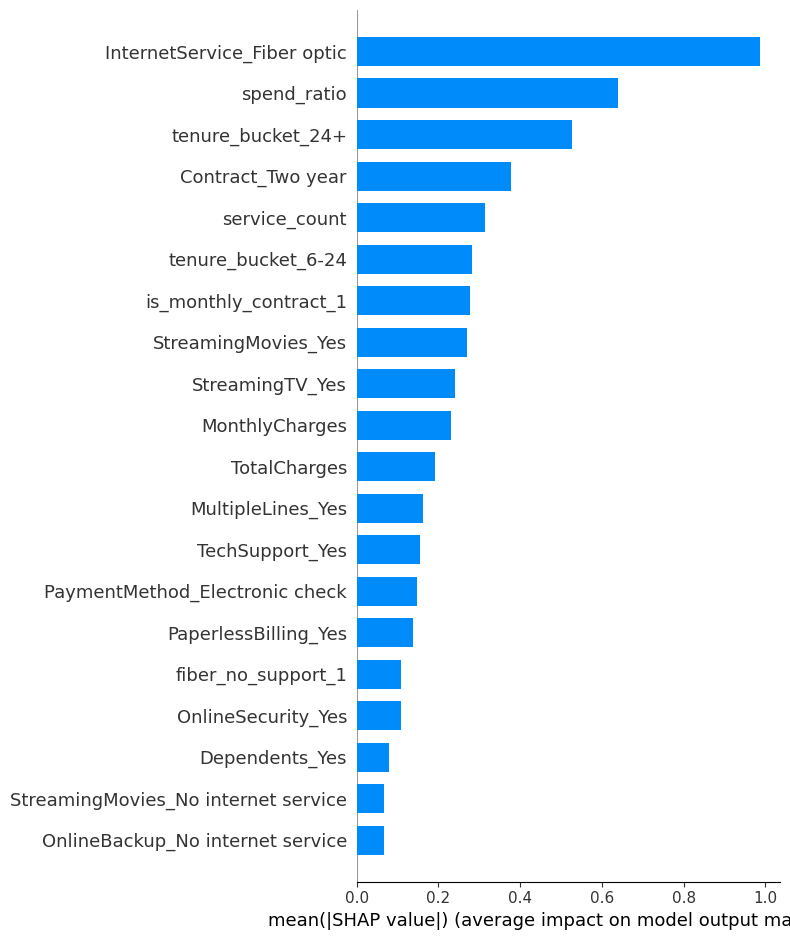

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=20)

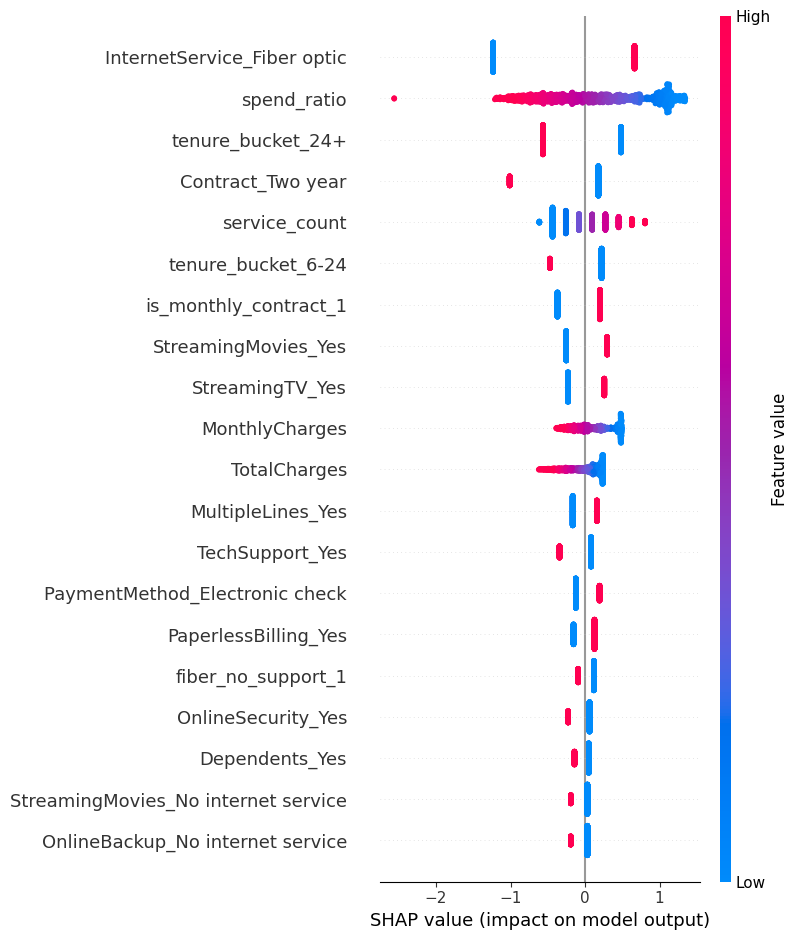

In [ ]:
shap.summary_plot(shap_values, X_test, max_display=20)

# Factors Influencing Churn Prediction

The SHAP analysis of our tuned Logistic Regression model highlights the following key drivers of customer churn, along with their direction of influence:

---

## Factors that increase churn risk
- **Month-to-month contracts**: Customers on monthly rolling contracts are much more likely to churn compared to those locked into one- or two-year agreements.  
- **Fiber optic internet service**: Customers with fiber connections show higher churn risk, likely due to cost perceptions or dissatisfaction with service quality.  
- **High spend ratio (TotalCharges / tenure)**: Customers who pay disproportionately high monthly charges relative to their tenure are more prone to leave.  
- **High MonthlyCharges**: Elevated monthly bills independently push customers toward churn, particularly when not offset by long tenure.  
- **Electronic check payments**: Customers using electronic check as a payment method churn more, possibly due to less convenience compared to AutoPay or credit card.  
- **Lack of bundled services/support**: Customers without technical support or security add-ons (especially fiber users without support) show increased churn.  
- **Streaming services (Movies/TV)**: Adoption of streaming add-ons slightly correlates with higher churn, suggesting these may raise monthly bills without increasing stickiness.  

---

## Factors that reduce churn risk
- **Long tenure (24+ months)**: Customers who have stayed longer are significantly less likely to churn — loyalty and switching barriers increase with time.  
- **Multi-year contracts (1–2 year)**: Longer contractual commitments provide strong protection against churn.  
- **Higher TotalCharges**: Although higher monthly charges increase churn, higher total lifetime spend generally reflects tenure and is protective.  
- **More services (service_count)**: Customers using multiple services (e.g., internet + phone + add-ons) are less likely to churn, benefiting from bundled value.  
- **Tech support & online security**: Customers with these add-ons have lower churn risk, suggesting these services add perceived value and reduce dissatisfaction.  
- **AutoPay/credit card payment methods**: More seamless payment options correlate with lower churn.  

---

## Summary
Overall, churn is driven primarily by **pricing pressure, lack of commitment, and absence of support/security services**. Conversely, **long-term relationships, multi-service bundles, and convenient payment methods** reduce churn risk.  

These insights can directly guide retention strategies, such as:
- Offering **contract upgrade incentives** to month-to-month customers.  
- Providing **discounts or loyalty rewards** for high spend ratio customers.  
- Promoting **bundled packages** (multiple services + support).  
- Encouraging **AutoPay enrollment** to reduce churn risk.  


## Conclusion

While we explored multiple advanced machine learning models, **Logistic Regression emerged as the most effective choice** for churn prediction in this dataset. It not only achieved the highest F1/F2 scores, but also provided interpretable insights into churn drivers.

Combined with SHAP feature analysis, the model highlights actionable factors (e.g., contract type, payment method, monthly charges) that the business can directly target in customer retention campaigns.